In [1]:
import numpy as np
import scipy.io as scio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import seaborn as sns
import cartopy
import matplotlib
from cartopy.util import add_cyclic_point

def reduced_dimension(variable_2D_lon_lat,times=4):
    signal_divide_noise1_reduced = variable_2D_lon_lat.copy()
    for i in range(360):
        for j in range(180):
            if i % times != 0 or j % times != 0:
                signal_divide_noise1_reduced[i, j] = np.nan
    return signal_divide_noise1_reduced

def central_transform(data2D):
    data2D_new=np.full((360,180),np.nan)
    data2D_new[180:361,:]=data2D[20:200,:]
    data2D_new[0:160,:]=data2D[200:360,:]
    data2D_new[160:180,:]=data2D[0:20,:]
    return data2D_new


In [2]:
#### load the individual Time of emergence (ToE) spatial data
data=scio.loadmat('./Input_data/ToE_temperautre_data_upper200_1000.mat')
lon=data['lon'][:]
lat=data['lat'][:]
ToE_warming=data['ToE_warming_upper200'][:]
ToE_warming[:,0:20]=np.nan #mask the polar regions
ToE_warming[:,158:180]=np.nan

data=scio.loadmat('./Input_data/ToE_salinity_data_upper200_1000.mat')
ToE_salinification=data['ToE_salting_upper200'][:]
ToE_freshening=data['ToE_freshing_upper200'][:]
ToE_salinification[:,0:20]=np.nan
ToE_salinification[:,158:180]=np.nan
ToE_freshening[:,0:20]=np.nan
ToE_freshening[:,158:180]=np.nan

data=scio.loadmat('./Input_data/ToE_oxygen_data_upper200_1000.mat')
ToE_deoxygenation=data['ToE_deoxygenation_upper200'][:]
ToE_deoxygenation[:,0:20]=np.nan
ToE_deoxygenation[:,158:180]=np.nan

In [3]:
#### load significant point flag
data=scio.loadmat('./Input_data/ToE_doubletriple_significant_flag_upper200.mat')
ToE_warming_freshening_significant_flag=data['ToE_warming_freshening_significant_flag'][:]
ToE_warming_salinification_significant_flag=data['ToE_warming_salinification_significant_flag'][:]
ToE_warming_salinification_deoxygenation_significant_flag=data['ToE_warming_salinification_deoxygenation_significant_flag'][:]
ToE_warming_freshen_deoxygenation_significant_flag=data['ToE_warming_freshen_deoxygenation_significant_flag'][:]
ToE_warming_deoxygenation_significant_flag=data['ToE_warming_deoxygenation_significant_flag'][:]

# load single compound CID significant flag
data=scio.loadmat('./Input_data/ToE_temperature_significant_flag_upper200_1000.mat')
ToE_NOT_significant_upper200=data['ToE_NOT_significant_upper200'][:] #1: not significant  0:significant
ToE_temperature_significant_upper200=np.copy(ToE_NOT_significant_upper200)
ToE_temperature_significant_upper200[ToE_temperature_significant_upper200==1]=2
ToE_temperature_significant_upper200[ToE_temperature_significant_upper200==0]=1
ToE_temperature_significant_upper200[ToE_temperature_significant_upper200==2]=0 #1: significant 0:not significant
del ToE_NOT_significant_upper200

data=scio.loadmat('./Input_data/ToE_oxygen_significant_flag_upper200_1000.mat')
ToE_NOT_significant_upper200=data['ToE_NOT_significant_upper200'][:] #1: not significant  0:significant
ToE_oxygen_significant_upper200=np.copy(ToE_NOT_significant_upper200)
ToE_oxygen_significant_upper200[ToE_oxygen_significant_upper200==1]=2
ToE_oxygen_significant_upper200[ToE_oxygen_significant_upper200==0]=1
ToE_oxygen_significant_upper200[ToE_oxygen_significant_upper200==2]=0 #1: significant 0:not significant
del ToE_NOT_significant_upper200

data=scio.loadmat('./Input_data/ToE_salinity_significant_flag_upper200_1000.mat')
ToE_NOT_significant_upper200=data['ToE_NOT_significant_upper200'][:] #1: not significant  0:significant
ToE_salinity_significant_upper200=np.copy(ToE_NOT_significant_upper200)
ToE_salinity_significant_upper200[ToE_salinity_significant_upper200==1]=2
ToE_salinity_significant_upper200[ToE_salinity_significant_upper200==0]=1
ToE_salinity_significant_upper200[ToE_salinity_significant_upper200==2]=0 #1: significant 0:not significant
del ToE_NOT_significant_upper200


In [4]:
####### find T+S+DO overlap grid
# warming+salinification+deoxygenation
isOverlap_warming_salin_deoxygen=np.logical_and(np.logical_and(~np.isnan(ToE_warming),~np.isnan(ToE_salinification)),~np.isnan(ToE_deoxygenation))
isOverlap_warming_fresh_deoxygen=np.logical_and(np.logical_and(~np.isnan(ToE_warming),~np.isnan(ToE_freshening)),~np.isnan(ToE_deoxygenation))

isOverlap_warming_salinification=np.logical_and(~np.isnan(ToE_warming),~np.isnan(ToE_salinification))
isOverlap_warming_salinification[isOverlap_warming_salin_deoxygen]=False
isOverlap_warming_freshening=np.logical_and(~np.isnan(ToE_warming),~np.isnan(ToE_freshening))
isOverlap_warming_freshening[isOverlap_warming_fresh_deoxygen]=False
isOverlap_warming_deoxygen=np.logical_and(~np.isnan(ToE_warming),~np.isnan(ToE_deoxygenation))
isOverlap_warming_deoxygen[isOverlap_warming_fresh_deoxygen]=False
isOverlap_warming_deoxygen[isOverlap_warming_salin_deoxygen]=False

TOE_overlap_warming_salin_deoxygen=np.full((360,180),np.nan)
TOE_overlap_warming_fresh_deoxygen=np.full((360,180),np.nan)
TOE_overlap_warming_fresh=np.full((360,180),np.nan)
TOE_overlap_warming_salin=np.full((360,180),np.nan)
TOE_overlap_warming_deoxygen=np.full((360,180),np.nan)
for i in range(360):
    for j in range(180):
        if(isOverlap_warming_salin_deoxygen[i,j]):
            TOE_overlap_warming_salin_deoxygen[i,j]=np.nanmax([ToE_warming[i,j],ToE_salinification[i,j],ToE_deoxygenation[i,j]])
        if(isOverlap_warming_fresh_deoxygen[i,j]):
            TOE_overlap_warming_fresh_deoxygen[i,j]=np.nanmax([ToE_warming[i,j],ToE_freshening[i,j],ToE_deoxygenation[i,j]])
        if(isOverlap_warming_salinification[i,j]):
            TOE_overlap_warming_salin[i,j]=np.nanmax([ToE_warming[i,j],ToE_salinification[i,j]])
        if(isOverlap_warming_freshening[i,j]):
            TOE_overlap_warming_fresh[i,j]=np.nanmax([ToE_warming[i,j],ToE_freshening[i,j]])
        if(isOverlap_warming_deoxygen[i,j]):
            TOE_overlap_warming_deoxygen[i,j]=np.nanmax([ToE_warming[i,j],ToE_deoxygenation[i,j]])

# find only warming
isOverlap=np.logical_or.reduce((~np.isnan(TOE_overlap_warming_salin_deoxygen),~np.isnan(TOE_overlap_warming_fresh_deoxygen),~np.isnan(TOE_overlap_warming_salin),~np.isnan(TOE_overlap_warming_fresh)))
ToE_onlyWarming=ToE_warming
ToE_onlyWarming[isOverlap]=np.nan
ToE_temperature_significant_upper200[np.isnan(ToE_onlyWarming)]=np.nan  #only keep the only warming significant point
ToE_onlyWarming_significant_upper200=np.copy(ToE_temperature_significant_upper200)

# find only deoxygenation
isOverlap=np.logical_or.reduce((~np.isnan(TOE_overlap_warming_salin_deoxygen),~np.isnan(TOE_overlap_warming_fresh_deoxygen),~np.isnan(TOE_overlap_warming_deoxygen)))
ToE_onlyDeoxygen=ToE_deoxygenation
ToE_onlyDeoxygen[isOverlap]=np.nan
ToE_oxygen_significant_upper200[np.isnan(ToE_onlyDeoxygen)]=np.nan  #only keep the only deoxygenation significant point
ToE_onlyDeoxygen_significant_upper200=np.copy(ToE_oxygen_significant_upper200)

# find only salinification
ToE_onlySalin_significant_upper200=np.copy(ToE_salinity_significant_upper200)
isOverlap=np.logical_or.reduce((~np.isnan(TOE_overlap_warming_salin_deoxygen),~np.isnan(TOE_overlap_warming_salin)))
ToE_onlySalin=ToE_salinification
ToE_onlySalin[isOverlap]=np.nan
ToE_onlySalin_significant_upper200[np.isnan(ToE_onlySalin)]=np.nan 

# find only freshening
ToE_onlyFresh_significant_upper200=np.copy(ToE_salinity_significant_upper200)
isOverlap=np.logical_or.reduce((~np.isnan(TOE_overlap_warming_fresh_deoxygen),~np.isnan(TOE_overlap_warming_fresh)))
ToE_onlyFresh=ToE_freshening
ToE_onlyFresh[isOverlap]=np.nan
ToE_onlyFresh_significant_upper200[np.isnan(ToE_onlyFresh)]=np.nan 


#### transform the data projection central longitude
TOE_overlap_warming_salin_deoxygen=central_transform(TOE_overlap_warming_salin_deoxygen)
TOE_overlap_warming_fresh_deoxygen=central_transform(TOE_overlap_warming_fresh_deoxygen)
TOE_overlap_warming_salin=central_transform(TOE_overlap_warming_salin)
TOE_overlap_warming_fresh=central_transform(TOE_overlap_warming_fresh)
ToE_onlyWarming=central_transform(ToE_onlyWarming)
ToE_onlyDeoxygen=central_transform(ToE_onlyDeoxygen)
TOE_overlap_warming_deoxygen=central_transform(TOE_overlap_warming_deoxygen)
ToE_onlySalin=central_transform(ToE_onlySalin)
ToE_onlyFresh=central_transform(ToE_onlyFresh)

#### transform the data projection central longitude
ToE_warming_freshening_significant_flag=central_transform(ToE_warming_freshening_significant_flag)
ToE_warming_salinification_significant_flag=central_transform(ToE_warming_salinification_significant_flag)
ToE_warming_salinification_deoxygenation_significant_flag=central_transform(ToE_warming_salinification_deoxygenation_significant_flag)
ToE_warming_freshen_deoxygenation_significant_flag=central_transform(ToE_warming_freshen_deoxygenation_significant_flag)
ToE_warming_deoxygenation_significant_flag=central_transform(ToE_warming_deoxygenation_significant_flag)
ToE_onlyWarming_significant_upper200=central_transform(ToE_onlyWarming_significant_upper200)
ToE_onlyDeoxygen_significant_upper200=central_transform(ToE_onlyDeoxygen_significant_upper200)
ToE_onlySalin_significant_upper200=central_transform(ToE_onlySalin_significant_upper200)
ToE_onlyFresh_significant_upper200=central_transform(ToE_onlyFresh_significant_upper200)

TOE_overlap_warming_salin_deoxygen, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_salin_deoxygen),(lon)[0])
TOE_overlap_warming_fresh_deoxygen, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_fresh_deoxygen),(lon)[0])
TOE_overlap_warming_salin, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_salin),(lon)[0])
TOE_overlap_warming_fresh, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_fresh),(lon)[0])
ToE_onlyWarming, cycle_lon = add_cyclic_point(np.transpose(ToE_onlyWarming),(lon)[0])
ToE_onlyDeoxygen, cycle_lon = add_cyclic_point(np.transpose(ToE_onlyDeoxygen),(lon)[0])
TOE_overlap_warming_deoxygen, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_deoxygen),(lon)[0])
ToE_onlySalin, cycle_lon = add_cyclic_point(np.transpose(ToE_onlySalin),(lon)[0])
ToE_onlyFresh, cycle_lon = add_cyclic_point(np.transpose(ToE_onlyFresh),(lon)[0])

In [5]:
######### create customize colorbars
blues=sns.color_palette('Blues_r',6)
blues=[blues[2],blues[4]]
new_blues=matplotlib.colors.ListedColormap(blues,name='new_blues')  #warming+freshening

# sns.palplot(sns.color_palette('Reds_r',6))
reds=sns.color_palette('Reds_r',6)
reds=[reds[2],reds[4]]
new_reds=matplotlib.colors.ListedColormap(reds,name='new_reds')  #only warming

# sns.palplot(sns.color_palette('YlGn_r',20))
pruples=sns.color_palette('YlGn_r',20)
pruples=[pruples[9],pruples[12]]
new_greens=matplotlib.colors.ListedColormap(pruples,name='new_greens')  #warming+salinification
# sns.palplot(pruples)

# sns.palplot(sns.color_palette('binary',100))
whites=sns.color_palette('binary',100)
whites=[whites[0],whites[0]]
new_whites=matplotlib.colors.ListedColormap(whites,name='new_whites')

# sns.palplot(sns.color_palette('YlGn_r',12))
dark_green=sns.color_palette('YlGn_r',12)
dark_greens=[dark_green[0],dark_green[3]]  #### warming+salinification+deoxygenation
new_dark_greens=matplotlib.colors.ListedColormap(dark_greens,name='new_dark_greens') 

# sns.palplot(sns.color_palette('PuOr',12))
browns=sns.color_palette('PuOr',12)
browns=[browns[0],browns[2]]  #### warming+freshening+deoxygenation
new_browns=matplotlib.colors.ListedColormap(browns,name='new_browns') 

# sns.palplot(sns.color_palette('tab20c',20))
blacks=sns.color_palette('tab20c',20)
blacks=[blacks[17],blacks[19]]  
new_blacks=matplotlib.colors.ListedColormap(blacks,name='new_blacks')  #### warming+deoxygenation

# sns.palplot(sns.color_palette('Purples_r',16))
purples=sns.color_palette('Purples_r',16)
purples=[purples[0],purples[3]]  
new_purples=matplotlib.colors.ListedColormap(purples,name='new_purples')  #### only deoxygenation

# sns.palplot(sns.color_palette('pink',20))
pinks=sns.color_palette('pink',20)
pinks=[pinks[6],pinks[10]]  
new_pinks=matplotlib.colors.ListedColormap(pinks,name='new_pinks')  #### only salinification
# sns.palplot(pinks)

# sns.palplot(sns.color_palette('bone',13))
bones=sns.color_palette('bone',13)
bones=[bones[7],bones[12]]  
new_bones=matplotlib.colors.ListedColormap(bones,name='new_bones')  #### only freshening
# sns.palplot(bones)

D:\anaconda3\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
D:\anaconda3\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


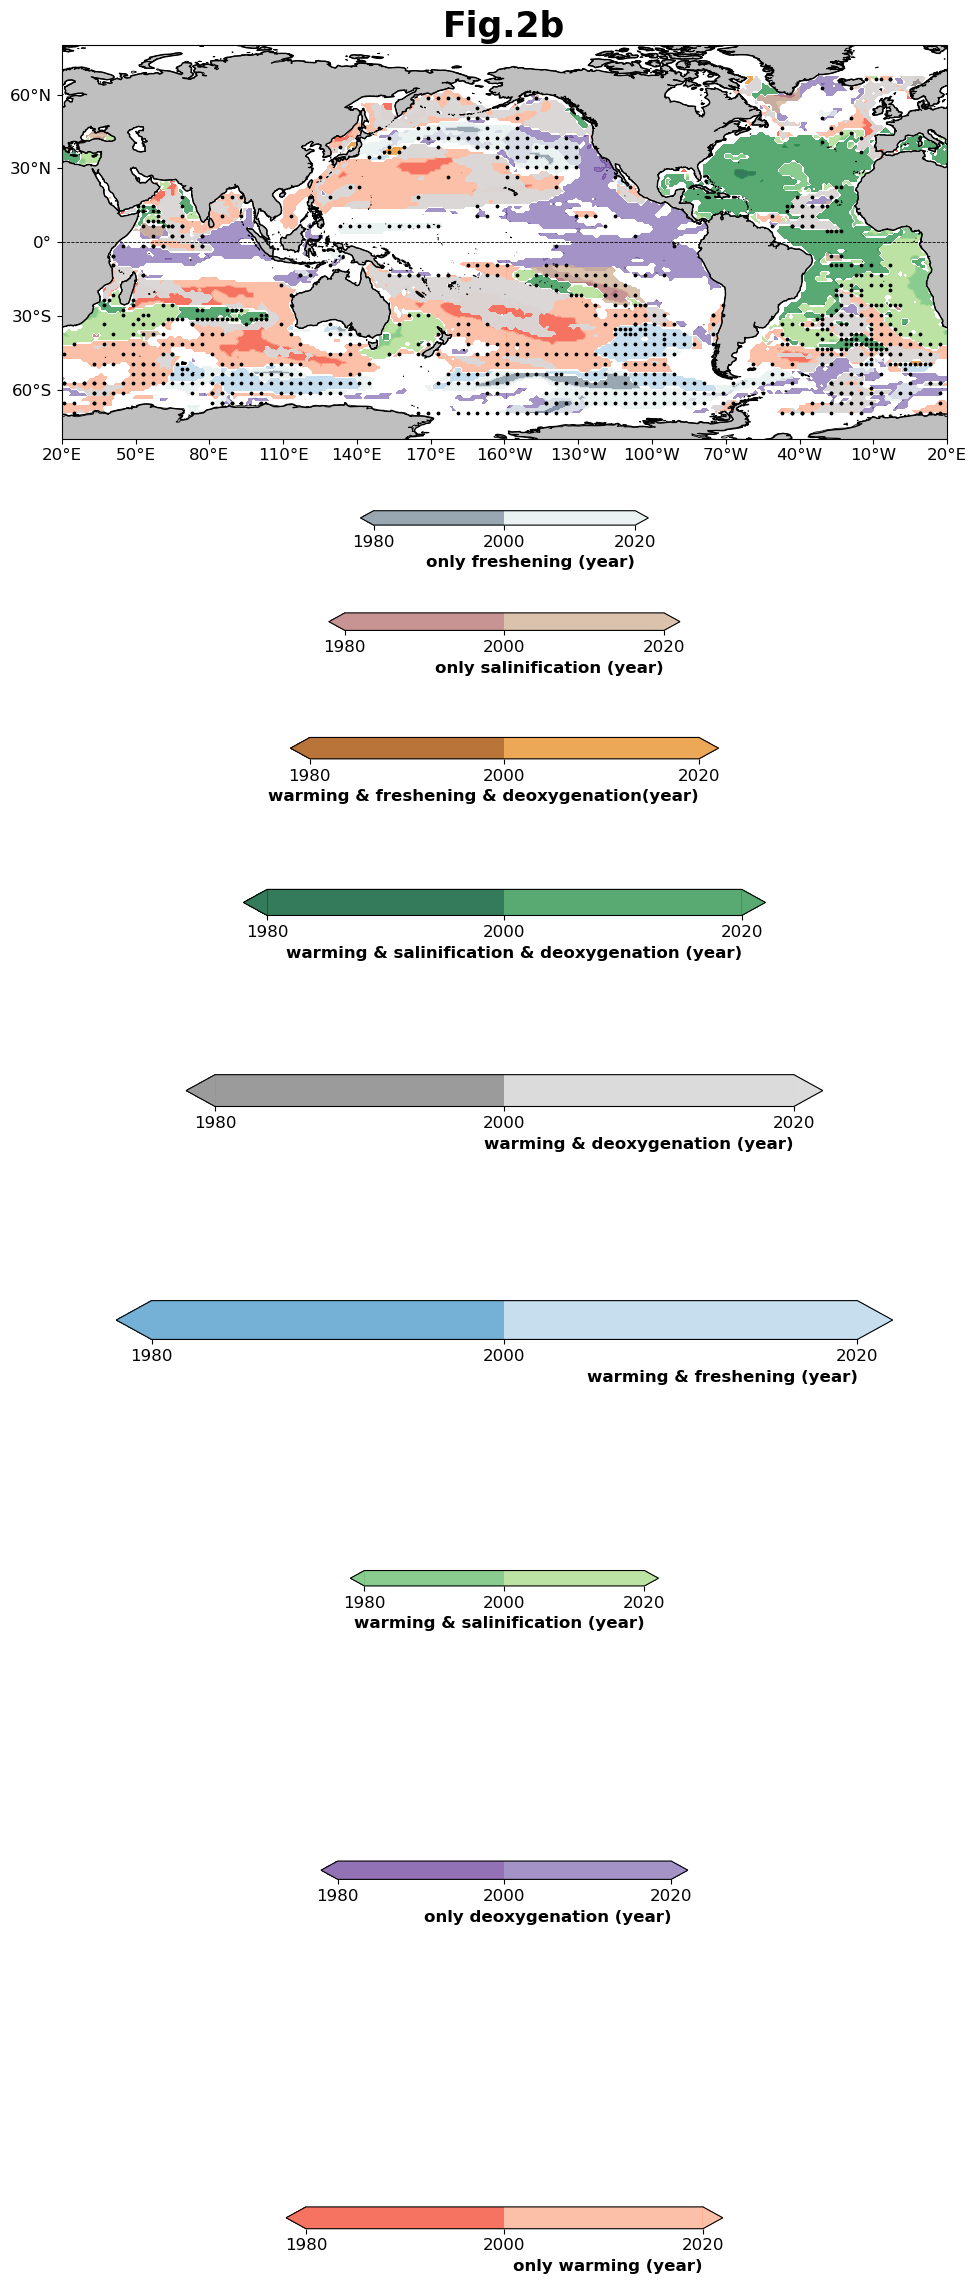

Fig.2b has been output to the /results/ folder


In [6]:
###### plot overlap

lon2d,lat2d=np.meshgrid(cycle_lon,lat)

fig=plt.figure(figsize=(15, 23))
plt.rcParams['font.size'] = '12'  # Font size
box=[-180,180,-90,90]
scale='50m'
xstep,ystep=30,30
proj=ccrs.PlateCarree(central_longitude=200)
ax2=plt.axes(projection=proj)   #create map and projection
ax2.plot([-180,180],[0,0],'--',linewidth=0.6,transform=proj,color='black')
ax2.add_feature(cfeature.LAND, facecolor='0.75')
ax2.add_feature(cfeature.COASTLINE, facecolor='0.75') 
ax2.coastlines(scale,linewidth=0.6)  #coastlines
ax2.set_xticks(np.arange(box[0], box[1] + xstep, xstep), crs=proj)
ax2.set_yticks(np.arange(box[2], box[3] + ystep, xstep), crs=proj)
lon_formatter = LongitudeFormatter(zero_direction_label=False)  
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter) 
ax2.yaxis.set_major_formatter(lat_formatter) 
ax2.set_extent([-180,180,-80,80],crs=proj)

#### plot contour lines
interval=np.arange(1980,2022,20)
cb1=ax2.contourf(lon2d,lat2d,(ToE_onlyWarming),interval,cmap=new_reds,alpha=0.80,extend='both',transform=proj)   
cb2=ax2.contourf(lon2d,lat2d,(ToE_onlyDeoxygen),interval,cmap=new_purples,alpha=0.60,extend='both',transform=proj)   
cb3=ax2.contourf(lon2d,lat2d,(TOE_overlap_warming_salin),interval,cmap=new_greens,alpha=0.8,extend='both',transform=proj)   #transform是固定的，用于把数据转换到cartopy中
cb4=ax2.contourf(lon2d,lat2d,(TOE_overlap_warming_fresh),interval,cmap=new_blues,alpha=0.8,extend='both',transform=proj)   #transform是固定的，用于把数据转换到cartopy中
cb5=ax2.contourf(lon2d,lat2d,(TOE_overlap_warming_deoxygen),interval,cmap=new_blacks,alpha=0.95,extend='both',transform=proj)
cb6=ax2.contourf(lon2d,lat2d,TOE_overlap_warming_salin_deoxygen,interval,cmap=new_dark_greens,alpha=0.80,extend='both',transform=proj)   
cb7=ax2.contourf(lon2d,lat2d,TOE_overlap_warming_fresh_deoxygen,interval,cmap=new_browns,alpha=0.80,extend='both',transform=proj)   
cb8=ax2.contourf(lon2d,lat2d,(ToE_onlySalin),interval,cmap=new_pinks,alpha=0.80,extend='both',transform=proj)   
cb9=ax2.contourf(lon2d,lat2d,(ToE_onlyFresh),interval,cmap=new_bones,alpha=0.80,extend='both',transform=proj)   

## putting insignificant dots
ToE_warming_freshening_significant_flag=reduced_dimension(ToE_warming_freshening_significant_flag)
row, col = np.where(ToE_warming_freshening_significant_flag == 0)  #insignificant points
lons=lon[0][row]
lats=lat[0][col]
cb10=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_warming_salinification_significant_flag=reduced_dimension(ToE_warming_salinification_significant_flag)
row, col = np.where(ToE_warming_salinification_significant_flag == 0)  #insignificant points
lons=lon[0][row]
lats=lat[0][col]
cb11=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_warming_deoxygenation_significant_flag=reduced_dimension(ToE_warming_deoxygenation_significant_flag)
row, col = np.where(ToE_warming_deoxygenation_significant_flag == 0) 
lons=lon[0][row]
lats=lat[0][col]
cb12=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_warming_salinification_deoxygenation_significant_flag=reduced_dimension(ToE_warming_salinification_deoxygenation_significant_flag,2)
row, col = np.where(ToE_warming_salinification_deoxygenation_significant_flag == 0) 
lons=lon[0][row]
lats=lat[0][col]
cb13=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_warming_freshen_deoxygenation_significant_flag=reduced_dimension(ToE_warming_freshen_deoxygenation_significant_flag,2)
row, col = np.where(ToE_warming_freshen_deoxygenation_significant_flag == 0)  
lons=lon[0][row]
lats=lat[0][col]
cb14=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlyWarming_significant_upper200=reduced_dimension(ToE_onlyWarming_significant_upper200,4)
row, col = np.where(ToE_onlyWarming_significant_upper200 == 0)  
lons=lon[0][row]
lats=lat[0][col]
cb15=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlyDeoxygen_significant_upper200=reduced_dimension(ToE_onlyDeoxygen_significant_upper200,4)
row, col = np.where(ToE_onlyDeoxygen_significant_upper200 == 0) 
lons=lon[0][row]
lats=lat[0][col]
cb16=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlySalin_significant_upper200=reduced_dimension(ToE_onlySalin_significant_upper200,4)
row, col = np.where(ToE_onlySalin_significant_upper200 == 0) 
lons=lon[0][row]
lats=lat[0][col]
cb17=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlyFresh_significant_upper200=reduced_dimension(ToE_onlyFresh_significant_upper200,4)
row, col = np.where(ToE_onlyFresh_significant_upper200 == 0)  
lons=lon[0][row]
lats=lat[0][col]
cb18=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

#### set colorbar
cbar1=fig.colorbar(cb1,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.01)
cbar2=fig.colorbar(cb2,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.01)
cbar3=fig.colorbar(cb3,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.01)
cbar4=fig.colorbar(cb4,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar5=fig.colorbar(cb5,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar6=fig.colorbar(cb6,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar7=fig.colorbar(cb7,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar8=fig.colorbar(cb8,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar9=fig.colorbar(cb9,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)

cbar1.set_label('only warming (year)', size=12, fontweight='bold', color='k',loc='right')
cbar2.set_label('only deoxygenation (year)', size=12, fontweight='bold', color='k',loc='right')
cbar3.set_label('warming & salinification (year)', size=12, fontweight='bold', color='k',loc='right')
cbar4.set_label('warming & freshening (year)', size=12, fontweight='bold', color='k',loc='right')
cbar5.set_label('warming & deoxygenation (year)', size=12, fontweight='bold', color='k',loc='right')
cbar6.set_label('warming & salinification & deoxygenation (year)', size=12, fontweight='bold', color='k',loc='right')
cbar7.set_label('warming & freshening & deoxygenation(year)', size=12, fontweight='bold', color='k',loc='right')
cbar8.set_label('only salinification (year)', size=12, fontweight='bold', color='k',loc='right')
cbar9.set_label('only freshening (year)', size=12, fontweight='bold', color='k',loc='right')
plt.title('Fig.2b',fontdict={'weight':'bold','size':25})
fig.tight_layout()

plt.savefig('/results/Fig2b.pdf', dpi=750, bbox_inches='tight')
plt.show()
print('Fig.2b has been output to the /results/ folder')